# Makes Live predictions for the week  -- ideally run it each Monday

In [1]:
import pickle
import os

folder_path = '/workspaces/BTC_PREDICTION/dev/artifacts/' 
# Save the model to a .pkl file in the specified folder
file_path = os.path.join(folder_path, 'catboost_model.pkl')

# Load the model from the .pkl file
with open(file_path, 'rb') as file:
    loaded_model = pickle.load(file)

In [2]:
loaded_model.feature_names_

['day_of_week',
 'month',
 'day',
 'pct_price_lag1',
 'pct_price_lag2',
 'pct_price_lag3',
 'pct_price_lag4',
 'pct_price_lag5',
 'pct_rolling_mean_3']

In [3]:
# Build my inference dataset
##determine the timeline

import pandas as pd
df = pd.read_csv("./artifacts/input.csv")
df.rename(columns={'price': 'btc_price'}, inplace=True)

In [4]:
# df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
from custom.training_functions import process_timestamp,daily_prices

#Initial preprocessing steps
df = process_timestamp(df)
df = daily_prices(df)

/workspaces/BTC_PREDICTION/dev/custom/training_functions.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('H')


In [6]:
df.tail(15)

,timestamp,btc_price
285,2025-12-11,78623.0
286,2025-12-12,78784.0
287,2025-12-13,76899.0
288,2025-12-14,76899.0
289,2025-12-15,75164.0
290,2025-12-16,73516.0
291,2025-12-17,74744.0
292,2025-12-18,73294.0
293,2025-12-19,72867.0
294,2025-12-20,75222.0


In [7]:
# # Define the end date
# end_date = pd.to_datetime('2025-12-12')

# # Filter the DataFrame to include only rows up to the end date
# df = df[df['timestamp'] < end_date]

In [8]:
# Convert the timestamp column to datetime format if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Identify the latest timestamp and corresponding price
latest_entry = df.loc[df['timestamp'].idxmax()]

latest_entry[['timestamp', 'btc_price']]

timestamp    2025-12-25 00:00:00
btc_price                74667.0
Name: 299, dtype: object

In [9]:
# Create an inference/forecasting table for the next 7 days
forecast_start_date = latest_entry['timestamp'] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=7, freq='D')

In [10]:


# Prepare the forecasting table
forecast_table = pd.DataFrame({
    'timestamp': forecast_dates,
    'pct_price_lag1': [None] * 7,
    'pct_price_lag2': [None] * 7,
    'pct_price_lag3': [None] * 7,
    'pct_price_lag4': [None] * 7,
    'pct_price_lag5': [None] * 7,
    'pct_rolling_mean_3': [None] * 7,
    'day_of_week': [None] * 7,
    'month': [None] * 7,
    'day': [None] * 7
})

In [11]:
forecast_table

,timestamp,pct_price_lag1,pct_price_lag2,pct_price_lag3,pct_price_lag4,pct_price_lag5,pct_rolling_mean_3,day_of_week,month,day
0,2025-12-26,None,None,None,None,None,None,None,None,None
1,2025-12-27,None,None,None,None,None,None,None,None,None
2,2025-12-28,None,None,None,None,None,None,None,None,None
3,2025-12-29,None,None,None,None,None,None,None,None,None
4,2025-12-30,None,None,None,None,None,None,None,None,None
5,2025-12-31,None,None,None,None,None,None,None,None,None
6,2026-01-01,None,None,None,None,None,None,None,None,None


In [12]:


# Load the model
folder_path = '/workspaces/BTC_PREDICTION/dev/artifacts/' 
file_path = os.path.join(folder_path, 'catboost_model.pkl')

with open(file_path, 'rb') as file:
    loaded_model = pickle.load(file)

# Data Preparation :


### Use a combination of historical data and predictions to create a live dataset with features

In [13]:
# Initialize last known price
last_known_price = latest_entry['btc_price']

# Fill in the historical prices for price_lag1 to price_lag5
historical_prices = df['btc_price'].tail(5).values.tolist()  # Get the last 5 historical prices

# Populate the forecast table with predictions
for i in range(7):
    # Prepare the input for the model
    lagged_prices = historical_prices[-5:]

    # # Use the last known price for any NaN values
    # lagged_prices = [last_known_price] + lagged_prices[:4]  # Start with the last known price

    # Compute features for prediction
    day_of_week = forecast_table['timestamp'].iloc[i].dayofweek  # 0 = Monday, 6 = Sunday
    month = forecast_table['timestamp'].iloc[i].month
    day = forecast_table['timestamp'].iloc[i].day

    # Store the day_of_week, month, and day in the forecast table
    forecast_table.loc[i, 'day_of_week'] = day_of_week
    forecast_table.loc[i, 'month'] = month
    forecast_table.loc[i, 'day'] = day

    # Calculate percentage price changes for lagged prices in reverse order
    pct_price_lags = [(lagged_prices[4-j] - lagged_prices[4-j-1]) / abs(lagged_prices[4-j-1]) * 100 if lagged_prices[4-j-1] != 0 else 0 for j in range(1, 6)]
    
    # Store the percentage price lags


    forecast_table.loc[i, 'pct_price_lag5'] = pct_price_lags[0]
    forecast_table.loc[i, 'pct_price_lag4'] = pct_price_lags[1]
    forecast_table.loc[i, 'pct_price_lag3'] = pct_price_lags[2]
    forecast_table.loc[i, 'pct_price_lag2'] = pct_price_lags[3]
    forecast_table.loc[i, 'pct_price_lag1'] = pct_price_lags[4]

    # act_price_lags = [lagged_prices[k] for k in range(0, 5)]

    # forecast_table.loc[i, 'act_price_lag5'] = act_price_lags[0]
    # forecast_table.loc[i, 'act_price_lag4'] = act_price_lags[1]
    # forecast_table.loc[i, 'act_price_lag3'] = act_price_lags[2]
    # forecast_table.loc[i, 'act_price_lag2'] = act_price_lags[3]
    # forecast_table.loc[i, 'act_price_lag1'] = act_price_lags[4]
    
    rolling_mean = forecast_table.loc[i-2:i, ['pct_price_lag1', 'pct_price_lag2', 'pct_price_lag3']].mean(axis=1).mean()
    # forecast_table['rolling_mean_3'] = df['btc_price'].rolling(window=3).mean()

    pct_rolling_mean = rolling_mean
    forecast_table.loc[i, 'pct_rolling_mean_3'] = pct_rolling_mean

    # Preparing the input features for prediction
    input_features = [day_of_week, month, day] + pct_price_lags + [pct_rolling_mean]

    # Make prediction using the loaded model
    predicted_pct_price = loaded_model.predict([input_features])[0]
    # Calculate the predicted price based on the last known price and predicted growth
    predicted_price = last_known_price * (1 + predicted_pct_price / 100)  # Convert percentage growth to actual price
    
    # Calculate day-to-day growth for the predicted price
    pct_price_growth = predicted_pct_price
    forecast_table.loc[i, 'pct_price_lag1'] = pct_price_growth

    # Update historical prices for lagging
    historical_prices.insert(0, predicted_price)  # Add the new predicted price to the historical prices
    historical_prices = historical_prices[:5]  # Keep only the last 5 prices




In [14]:
forecast_table

,timestamp,pct_price_lag1,pct_price_lag2,pct_price_lag3,pct_price_lag4,pct_price_lag5,pct_rolling_mean_3,day_of_week,month,day
0,2025-12-26,2.460057,1.029906,0.291638,-0.582902,-1.471781,0.69195,4,12,26
1,2025-12-27,1.59016,3.232917,-1.395813,0.291638,-0.582902,0.691154,5,12,27
2,2025-12-28,2.677759,0.849996,0.856281,-1.395813,0.291638,0.925804,6,12,28
3,2025-12-29,2.253658,1.335522,-1.059236,0.856281,-1.395813,0.931025,0,12,29
4,2025-12-30,1.823514,1.211277,0.414754,-1.059236,0.856281,0.7938,1,12,30
5,2025-12-31,1.892829,-0.62126,0.422441,0.414754,-1.059236,0.737439,2,12,31
6,2026-01-01,0.590311,0.297932,-0.068028,0.422441,0.414754,0.479358,3,1,1


In [15]:

#  Set timestamp as index
forecast_table['timestamp'] = pd.to_datetime(forecast_table['timestamp'])
forecast_table.set_index('timestamp', inplace=True)

In [16]:
from catboost import Pool
# Extract input features for prediction
input_features = forecast_table[['pct_price_lag1', 'pct_price_lag2', 'pct_price_lag3', 
                                  'pct_price_lag4', 'pct_price_lag5', 'pct_rolling_mean_3', 
                                  'day_of_week', 'month', 'day']]

# Convert day_of_week, month, and day to categorical features
input_features['day_of_week'] = input_features['day_of_week'].astype('category')
input_features['month'] = input_features['month'].astype('category')
input_features['day'] = input_features['day'].astype('category')
cat_features_indices = [6, 7, 8]  # Indices of day_of_week, month, and day in input_features
pool = Pool(data=input_features, cat_features=cat_features_indices)
# Make predictions using CatBoost
forecast_table['forecasted_btc_growth'] = loaded_model.predict(pool)

In [17]:
forecast_table['forecasted_btc_price'] = 0.0  # Initialize the column
forecast_table['forecasted_btc_price'].iloc[0] = latest_entry[1] * (1 + (0.01*forecast_table['forecasted_btc_growth'].iloc[0]))

/tmp/ipykernel_6198/3929732333.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_table['forecasted_btc_price'].iloc[0] = latest_entry[1] * (1 + (0.01*forecast_table['forecasted_btc_growth'].iloc[0]))
/tmp/ipykernel_6198/3929732333.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` inst

In [18]:
# Calculate subsequent values
for i in range(1, len(forecast_table)):
    forecast_table['forecasted_btc_price'].iloc[i] = forecast_table['forecasted_btc_price'].iloc[i - 1] * (1 + (0.01*forecast_table['forecasted_btc_growth'].iloc[i]))


/tmp/ipykernel_6198/3881470927.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  forecast_table['forecasted_btc_price'].iloc[i] = forecast_table['forecasted_btc_price'].iloc[i - 1] * (1 + (0.01*forecast_table['forecasted_btc_growth'].iloc[

In [19]:
# Display the forecasting table
print(forecast_table)

           pct_price_lag1 pct_price_lag2 pct_price_lag3 pct_price_lag4  \
timestamp                                                                
2025-12-26       2.460057       1.029906       0.291638      -0.582902   
2025-12-27        1.59016       3.232917      -1.395813       0.291638   
2025-12-28       2.677759       0.849996       0.856281      -1.395813   
2025-12-29       2.253658       1.335522      -1.059236       0.856281   
2025-12-30       1.823514       1.211277       0.414754      -1.059236   
2025-12-31       1.892829       -0.62126       0.422441       0.414754   
2026-01-01       0.590311       0.297932      -0.068028       0.422441   

           pct_price_lag5 pct_rolling_mean_3 day_of_week month day  \
timestamp                                                            
2025-12-26      -1.471781            0.69195           4    12  26   
2025-12-27      -0.582902           0.691154           5    12  27   
2025-12-28       0.291638           0.925804         

In [20]:
forecast_table_2 = pd.DataFrame(forecast_table,columns = ['forecasted_btc_price'])

In [21]:
forecast_table_2.reset_index(inplace=True)

In [22]:
forecast_table_2

,timestamp,forecasted_btc_price
0,2025-12-26,74291.169540
1,2025-12-27,73092.584636
2,2025-12-28,73310.413957
3,2025-12-29,73287.790777
4,2025-12-30,73591.149041
5,2025-12-31,74229.454036
6,2026-01-01,74626.429054


In [23]:
df_validation = pd.read_csv("./artifacts/btc_validation.csv")
df_validation.rename(columns={'price': 'btc_price'}, inplace=True)

In [24]:
import sys
import os

# Set the base directory where the custom module is located
base_dir = '/workspaces/BTC_PREDICTION'  # Adjust this path as needed

# Add the parent directory of the current working directory to sys.path
sys.path.append(os.path.join(base_dir, 'dev'))

In [25]:
from custom.training_functions import process_timestamp,daily_prices

#Initial preprocessing steps
df_validation = process_timestamp(df_validation)
df_validation = daily_prices(df_validation)

/workspaces/BTC_PREDICTION/dev/custom/training_functions.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('H')


In [26]:
df_validation.tail(10)

,timestamp,btc_price
290,2025-12-02,74329.0
291,2025-12-03,78545.0
292,2025-12-04,80248.0
293,2025-12-05,79148.0
294,2025-12-06,76688.0
295,2025-12-07,76644.0
296,2025-12-08,77445.0
297,2025-12-09,77853.0
298,2025-12-10,79740.0
299,2025-12-11,77907.5


In [27]:
#merge and form the final table

final_validation_table = pd.merge(forecast_table_2,df_validation,on = "timestamp",how = "left")

In [28]:
final_validation_table

,timestamp,forecasted_btc_price,btc_price
0,2025-12-26,74291.169540,NaN
1,2025-12-27,73092.584636,NaN
2,2025-12-28,73310.413957,NaN
3,2025-12-29,73287.790777,NaN
4,2025-12-30,73591.149041,NaN
5,2025-12-31,74229.454036,NaN
6,2026-01-01,74626.429054,NaN


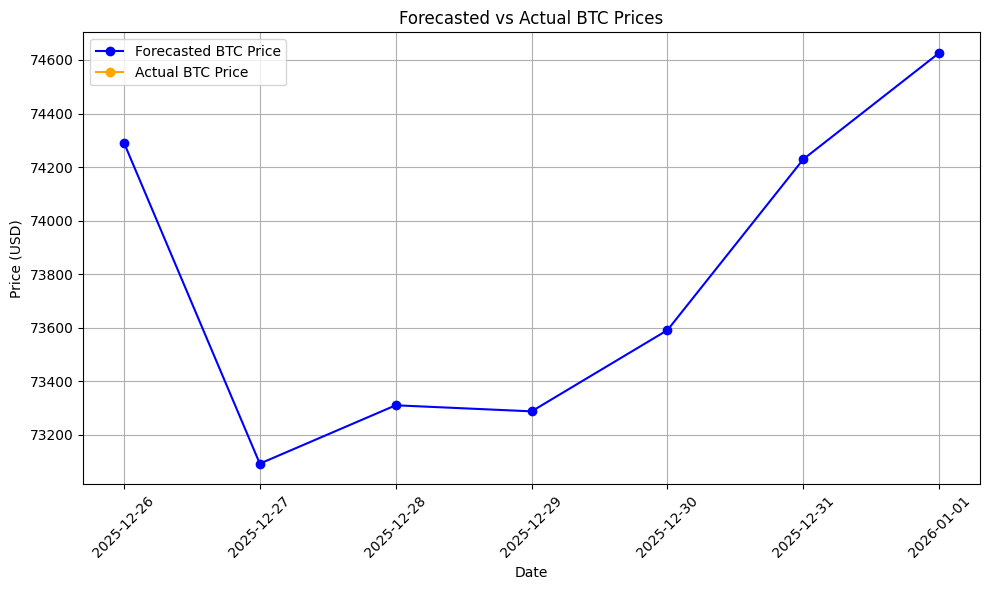

In [29]:
import matplotlib.pyplot as plt

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(final_validation_table['timestamp'], final_validation_table['forecasted_btc_price'], marker='o', label='Forecasted BTC Price', color='blue')
plt.plot(final_validation_table['timestamp'], final_validation_table['btc_price'], marker='o', label='Actual BTC Price', color='orange')

# Adding titles and labels
plt.title('Forecasted vs Actual BTC Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()